* [*.dat] : https://archive.ics.uci.edu/ml/machine-learning-databases/00224/

#Part4. [실습10] 제조 공정 내 가스 혼합물의 개별 가스 성분 분류

* matplotlib 한글 깨짐 현상 해결
> 셀 실행 후 런타임 재시작 필요

In [ ]:
# !apt-get update -qq
# !apt-get install fonts-nanum* -qq

# import matplotlib.font_manager as fm
# from matplotlib import pyplot as plt

# path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'
# font_name = fm.FontProperties(fname=path, size=10).get_name()

# plt.rc('font', family=font_name)

# fm._rebuild()

In [ ]:
from matplotlib import pyplot as plt
plt.rc('font', family='NanumBarunGothic') 

## 01. 데이터 소개 및 분석프로세스 수립
 : "강의자료 → Ch11. [실습9] 가스 터빈 추진 플랜트 제조 공정의 부식 예측" 참고

## 02. 데이터 준비를 위한 EDA 및 전처리

### 0. 데이터 불러오기

In [ ]:
############################################## 00. 필요한 파이썬 라이브러리 불러오기 #####################################################
import os
import time
import glob
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

from sklearn.decomposition import PCA 
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [ ]:
path = '/content/drive/MyDrive/강의/실습자료/data/ch12'
all_files = glob.glob(os.path.join(path, "*.dat"))

In [ ]:
df_from_each_file = (pd.read_csv(f, sep="\s+",index_col=0, header=None) for f in all_files)
df = pd.concat(df_from_each_file, sort=True)

# 각 셀마다 feature 와 value 를 나눠준다 (예 --> 1:15596.16 ---> 15596.16)
for col in df.columns.values:
    df[col] = df[col].apply(lambda x: float(str(x).split(':')[1]))

df = df.rename_axis('Gas').reset_index()

df.sort_values(by=['Gas'],inplace=True)
df.reset_index(drop=True,inplace=True)

### 1. 데이터 탐색

####1) Basic

In [ ]:
df.Gas.nunique()

6

In [ ]:
df.head()

,Gas,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128
0,1,15596.1621,1.868245,2.371604,2.803678,7.512213,-2.739388,-3.344671,-4.847512,15326.6914,1.768526,2.269085,2.713374,6.915721,-2.488324,-3.082212,-5.056975,2789.3831,2.754759,0.430440,0.649457,1.795029,-0.426662,-0.584313,-1.438976,2581.5686,2.680623,0.399746,0.605065,1.786704,-0.400115,-0.550743,-1.728611,685.3994,1.682904,0.122736,0.223703,0.584691,-0.138196,-0.236907,...,2185.9741,2.949381,0.342575,0.515090,1.340477,-0.361030,-0.493482,-1.200617,862.7479,1.779291,0.165138,0.246473,1.358106,-0.187465,-0.416382,-1.058061,1059.7562,1.896047,0.198946,0.334017,0.815048,-0.204467,-0.345119,-0.969336,3357.1124,3.860647,0.580818,0.806830,1.729739,-0.619214,-1.071137,-3.037772,3037.0390,3.972203,0.527291,0.728443,1.445783,-0.545079,-0.902241,-2.654529
1,1,63977.7696,4.167595,16.585249,23.251074,30.609595,-13.523380,-18.412358,-63.868994,48405.8652,2.754066,13.497138,19.958221,33.281066,-11.275762,-16.037687,-48.807572,11817.0930,4.572676,3.073228,6.686113,8.987955,-2.794705,-4.114651,-8.799352,12009.9065,4.486397,3.191784,6.814771,9.890921,-2.864425,-4.244426,-7.519559,3966.5544,2.951857,1.472888,3.933471,7.115419,-1.085608,-1.903061,...,11422.9468,4.692882,3.156244,6.612181,9.238423,-2.723495,-4.131521,-9.224363,4467.6554,3.192842,1.698924,4.693181,8.130750,-1.210260,-2.090758,-5.359044,3864.4237,3.029658,1.399340,4.056797,6.528611,-1.017463,-1.880344,-5.620730,18836.5937,5.165475,6.237392,14.031837,18.910534,-5.373498,-9.151316,-20.096582,16536.5271,5.146451,5.920137,14.026265,18.070481,-4.893835,-8.622448,-16.032358
2,1,85799.9199,5.391654,22.510086,31.963378,44.852442,-17.641179,-24.564141,-107.636673,66325.9082,3.496136,18.456762,28.162225,38.541891,-14.943008,-21.976508,-80.793801,17674.5044,6.788889,4.547327,8.332182,11.314767,-4.247248,-6.536620,-13.367045,17895.5112,6.602047,4.663164,8.735594,11.403216,-4.356930,-6.626092,-14.237014,5576.2280,3.844258,1.967586,4.774495,7.362195,-1.494095,-2.591652,...,16954.0144,6.901817,4.584255,8.411523,11.081576,-4.051694,-6.371402,-12.630358,6248.5824,4.216960,2.235465,5.691430,8.955101,-1.675226,-2.919773,-6.685465,5502.7336,4.039914,1.828858,4.786054,7.699655,-1.425835,-2.446651,-6.289898,28205.7730,7.731637,9.342144,18.053748,21.575025,-8.224113,-14.613964,-27.706487,24568.0573,7.695328,8.698242,17.799126,22.388913,-7.400848,-13.436990,-26.384947
3,1,4409.8086,1.213460,3.406728,6.188410,10.552296,-1.356137,-2.284334,-10.406550,1867.1621,1.065751,2.977926,6.075863,13.779786,-1.356440,-2.422959,-12.605521,999.4246,1.297679,1.177730,3.799299,7.103504,-0.313990,-0.614501,-3.026209,1052.9285,1.302524,1.237472,3.931129,7.074447,-0.331318,-0.651927,-2.728831,472.2039,1.233715,0.722117,2.478192,5.261009,-0.170893,-0.490865,...,1012.8112,1.316126,1.212298,3.632647,6.242435,-0.326712,-0.663904,-3.283598,590.9350,1.291361,0.875219,3.050917,5.722232,-0.201898,-0.510264,-3.027299,493.0159,1.259506,0.754185,2.692012,5.180458,-0.181103,-0.489525,-2.879709,1818.6533,1.391062,2.705440,8.574963,12.827542,-0.587286,-1.050682,-4.506671,1670.9245,1.413573,2.598768,8.587894,12.007572,-0.539856,-0.979863,-3.640232
4,1,64055.1973,4.105238,16.755247,23.226888,32.291462,-13.621875,-18.514037,-63.210391,48343.5762,2.728235,13.541813,20.079315,29.759307,-11.241122,-15.584867,-57.951439,11747.9180,4.546815,3.106561,6.774248,9.239448,-2.794424,-4.238900,-9.237991,11910.9485,4.432412,3.219480,6.822684,9.680207,-2.860117,-4.445493,-8.143785,3965.6500,2.952543,1.479039,3.847498,6.379700,-1.080555,-1.828659,...,11330.8694,4.630623,3.168742,6.593356,9.613930,-2.702708,-4.122085,-9.144837,4442.8331,3.180153,1.691856,4.621961,7.487482,-1.210097,-2.187651,-5.973421,3881.2165,3.036504,1.396383,4.104580,7.075910,-1.027726,-1.812453,-4.667080,18833.3335,5.14019

In [ ]:
df.shape

(10297, 129)

#### 2) 데이터 타입

In [ ]:
pd.unique(df.dtypes),len(df.select_dtypes(exclude='object').columns) - 1

(array([dtype('int64'), dtype('float64')], dtype=object), 128)

#### 3) 데이터 통계값

In [ ]:
df.describe()

,Gas,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128
count,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,...,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000,10297.000000
mean,3.354375,60932.926893,6.921457,15.593265,22.446524,31.482775,-11.050742,-17.187808,-73.500582,61099.219699,6.745571,16.327312,24.515977,34.741336,-10.864916,-17.546205,-81.647753,16452.128550,6.226498,5.251710,9.685291,13.456979,-3.668839,-5.665038,-12.326906,16543.168554,6.076192,5.326474,10.058012,15.504585,-3.658632,-5.750560,-13.170862,3835.490176,3.217708,1.401306,3.465707,5.660664,-0.902596,-1.584768,...,15198.449922,6.200179,4.663886,8.227872,11.078999,-3.368663,-5.061491,-11.005736,4918.932911,3.547960,1.816756,4.680545,7.429698,-1.144713,-2.003416,-4.771959,5013.859712,3.596778,1.774581,4.402851,6.952112,-1.127433,-1.895040,-4.544532,22587.291827,6.758185,8.124372,16.940123,21.581833,-5.788701,-9.905655,-19.786907,19890.072324,6.572197,7.099024,14.701535,18.631779,-5.006153,-8.415964,-16.490977
std,1.727556,76594.587104,14.992234,19.209576,27.030658,42.130950,13.930121,23.308064,148.573551,70550.745135,17.880932,18.180485,26.859190,47.034455,12.162932,23.606446,180.438969,12045.403338,4.806714,4.099749,9.843059,45.327051,3.108410,5.103378,12.952809,11740.565275,4.844558,4.398649,13.112085,128.216111,3.055373,7.512610,46.057758,2503.551746,3.741748,0.881273,2.563901,6.282844,0.657814,1.698495,...,11191.807628,4.790831,3.503433,6.567508,7.538590,2.859514,4.482178,13.623090,2890.862987,1.776873,1.051791,3.137982,5.306846,0.755693,1.366714,5.432018,2936.288719,1.859933,1.013566,2.947315,5.136613,0.740601,1.280982,4.979049,17662.778371,5.430697,6.363855,14.438226,17.379672,5.413052,10.105974,30.162546,15229.281049,5.130443,5.416428,12.293742,13.955745,4.545834,8.375290,23.802632
min,1.000000,-16757.598600,0.088287,0.000100,0.000100,0.000100,-131.332873,-227.627758,-1664.735576,-16119.460900,0.185164,0.002252,0.020647,0.000100,-88.523778,-249.508514,-1922.637410,-22110.726500,0.226896,0.001738,0.007875,0.103424,-18.618364,-85.109074,-355.474930,-23660.634800,0.209933,0.000100,0.000100,0.000100,-42.152371,-406.576259,-2946.481557,-1323.890200,0.696367,0.003074,0.040015,0.227690,-12.562238,-131.697907,...,-8441.724600,0.683912,0.003351,0.033390,0.000100,-18.050700,-38.455448,-377.707777,-1045.338400,0.828698,0.005965,0.058550,0.312217,-4.240221,-40.578894,-404.909860,-1171.561600,0.820610,0.001948,0.054492,0.380956,-3.804284,-39.845058,-397.184324,-9231.119100,0.717645,0.000219,0.000100,0.000100,-36.163600,-76.069200,-482.278033,-8297.548800,0.712112,0.003238,0.011488,0.118849,-30.205911,-58.844076,-410.152297
25%,2.000000,8363.481600,2.451165,2.119093,2.970733,5.414229,-15.433349,-21.951278,-57.976837,12197.073700,2.786761,3.380194,5.028058,7.998132,-14.107928,-20.292103,-59.134400,7390.859300,2.943298,2.187731,3.567726,6.422066,

### 2. Feature 정의

#### 1) Target Feature



> Ethanol
Ethylene
Ammonia
Acetaldehyde
Acetone
Toluene

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


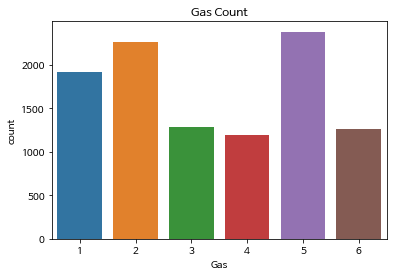

In [ ]:
sns.countplot(df.Gas)
sns.set(style="darkgrid")
plt.title('Gas Count')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


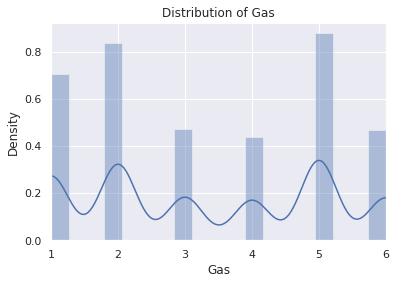

In [ ]:
sns.distplot(df.Gas)
plt.xlim(1, 6)
plt.title('Distribution of Gas')
plt.show()

#### 2) 농도가 다른 컬럼 확인

In [ ]:
conc = df.iloc[:,1]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


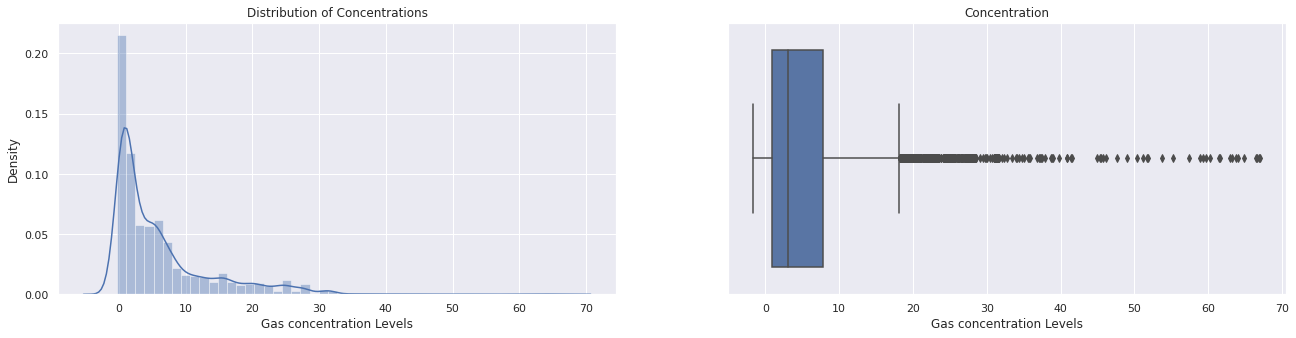

In [ ]:
conc_red = conc.apply(lambda x: x/10000)

fig = plt.figure(figsize=(22, 5))
fig.add_subplot(121)
sns.distplot(conc_red)
plt.title('Distribution of Concentrations')
plt.xlabel('Gas concentration Levels')

fig.add_subplot(122)
sns.boxplot(conc_red)
plt.title('Concentration')
plt.xlabel('Gas concentration Levels')

plt.show()

#### 3) 데이터 확인

In [ ]:
attr = df.iloc[:,2:].copy()
attr.head()

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,...,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128
0,1.868245,2.371604,2.803678,7.512213,-2.739388,-3.344671,-4.847512,15326.6914,1.768526,2.269085,2.713374,6.915721,-2.488324,-3.082212,-5.056975,2789.3831,2.754759,0.430440,0.649457,1.795029,-0.426662,-0.584313,-1.438976,2581.5686,2.680623,0.399746,0.605065,1.786704,-0.400115,-0.550743,-1.728611,685.3994,1.682904,0.122736,0.223703,0.584691,-0.138196,-0.236907,-0.781959,797.7738,...,2185.9741,2.949381,0.342575,0.515090,1.340477,-0.361030,-0.493482,-1.200617,862.7479,1.779291,0.165138,0.246473,1.358106,-0.187465,-0.416382,-1.058061,1059.7562,1.896047,0.198946,0.334017,0.815048,-0.204467,-0.345119,-0.969336,3357.1124,3.860647,0.580818,0.806830,1.729739,-0.619214,-1.071137,-3.037772,3037.0390,3.972203,0.527291,0.728443,1.445783,-0.545079,-0.902241,-2.654529
1,4.167595,16.585249,23.251074,30.609595,-13.523380,-18.412358,-63.868994,48405.8652,2.754066,13.497138,19.958221,33.281066,-11.275762,-16.037687,-48.807572,11817.0930,4.572676,3.073228,6.686113,8.987955,-2.794705,-4.114651,-8.799352,12009.9065,4.486397,3.191784,6.814771,9.890921,-2.864425,-4.244426,-7.519559,3966.5544,2.951857,1.472888,3.933471,7.115419,-1.085608,-1.903061,-4.753987,3343.4076,...,11422.9468,4.692882,3.156244,6.612181,9.238423,-2.723495,-4.131521,-9.224363,4467.6554,3.192842,1.698924,4.693181,8.130750,-1.210260,-2.090758,-5.359044,3864.4237,3.029658,1.399340,4.056797,6.528611,-1.017463,-1.880344,-5.620730,18836.5937,5.165475,6.237392,14.031837,18.910534,-5.373498,-9.151316,-20.096582,16536.5271,5.146451,5.920137,14.026265,18.070481,-4.893835,-8.622448,-16.032358
2,5.391654,22.510086,31.963378,44.852442,-17.641179,-24.564141,-107.636673,66325.9082,3.496136,18.456762,28.162225,38.541891,-14.943008,-21.976508,-80.793801,17674.5044,6.788889,4.547327,8.332182,11.314767,-4.247248,-6.536620,-13.367045,17895.5112,6.602047,4.663164,8.735594,11.403216,-4.356930,-6.626092,-14.237014,5576.2280,3.844258,1.967586,4.774495,7.362195,-1.494095,-2.591652,-5.110862,4691.5089,...,16954.0144,6.901817,4.584255,8.411523,11.081576,-4.051694,-6.371402,-12.630358,6248.5824,4.216960,2.235465,5.691430,8.955101,-1.675226,-2.919773,-6.685465,5502.7336,4.039914,1.828858,4.786054,7.699655,-1.425835,-2.446651,-6.289898,28205.7730,7.731637,9.342144,18.053748,21.575025,-8.224113,-14.613964,-27.706487,24568.0573,7.695328,8.698242,17.799126,22.388913,-7.400848,-13.436990,-26.384947
3,1.213460,3.406728,6.188410,10.552296,-1.356137,-2.284334,-10.406550,1867.1621,1.065751,2.977926,6.075863,13.779786,-1.356440,-2.422959,-12.605521,999.4246,1.297679,1.177730,3.799299,7.103504,-0.313990,-0.614501,-3.026209,1052.9285,1.302524,1.237472,3.931129,7.074447,-0.331318,-0.651927,-2.728831,472.2039,1.233715,0.722117,2.478192,5.261009,-0.170893,-0.490865,-2.351480,394.6684,...,1012.8112,1.316126,1.212298,3.632647,6.242435,-0.326712,-0.663904,-3.283598,590.9350,1.291361,0.875219,3.050917,5.722232,-0.201898,-0.510264,-3.027299,493.0159,1.259506,0.754185,2.692012,5.180458,-0.181103,-0.489525,-2.879709,1818.6533,1.391062,2.705440,8.574963,12.827542,-0.587286,-1.050682,-4.506671,1670.9245,1.413573,2.598768,8.587894,12.007572,-0.539856,-0.979863,-3.640232
4,4.105238,16.755247,23.226888,32.291462,-13.621875,-18.514037,-63.210391,48343.5762,2.728235,13.541813,20.079315,29.759307,-11.241122,-15.584867,-57.951439,11747.9180,4.546815,3.106561,6.774248,9.239448,-2.794424,-4.238900,-9.237991,11910.9485,4.432412,3.219480,6.822684,9.680207,-2.860117,-4.445493,-8.143785,3965.6500,2.952543,1.479039,3.847498,6.379700,-1.080555,-1.828659,-3.740131,3350.7127,...,11330.8694,4.630623,3.168742,6.593356,9.613930,-2.702708,-4.122085,-9.144837,4442.8331,3.180153,1.691856,4.621961,7.487482,-1.210097,-2.187651,-5.973421,3881.2165,3.036504,1.396383,4.104580,7.075910,-1.027726,-1.8

#### 4) 상관도 분석

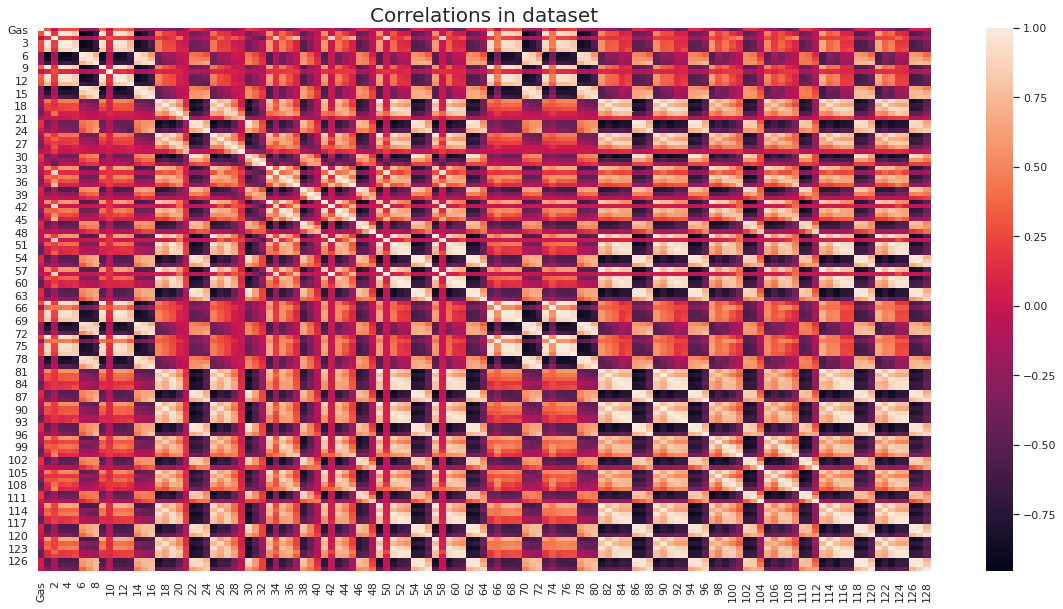

In [ ]:
# 상관계수 계산
correlation = df.corr()

# Heatmap 그리기
f, ax = plt.subplots(figsize=(20,10))
plt.title('Correlations in dataset', size=20)
sns.heatmap(correlation)
plt.show()

> 상관계수 상위 20개 (양수,음수)

In [ ]:
# 상관계수 정렬
conc_corr = correlation.iloc[:,1].sort_values(ascending=False)

# 상위 20개 (양수)
conc_corr[1:].head(20)

3      0.982808
9      0.965206
4      0.964114
65     0.953127
73     0.951234
11     0.950724
67     0.925952
12     0.922700
75     0.922094
68     0.897889
76     0.895032
5      0.840761
77     0.814406
69     0.796663
13     0.718498
121    0.616142
113    0.615495
49     0.560046
33     0.556911
41     0.548318
Name: 1, dtype: float64

In [ ]:
# 상위 20개 (음수)
conc_corr[1:].tail(20)

62    -0.465270
119   -0.468035
127   -0.476130
46    -0.478495
38    -0.479150
54    -0.486077
72    -0.486383
118   -0.526704
80    -0.526841
126   -0.533942
16    -0.541191
8     -0.658674
71    -0.761582
15    -0.771644
79    -0.805916
7     -0.878785
78    -0.889677
70    -0.893199
14    -0.917637
6     -0.947062
Name: 1, dtype: float64

#### 5) 상관도 기준 관계 그래프

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

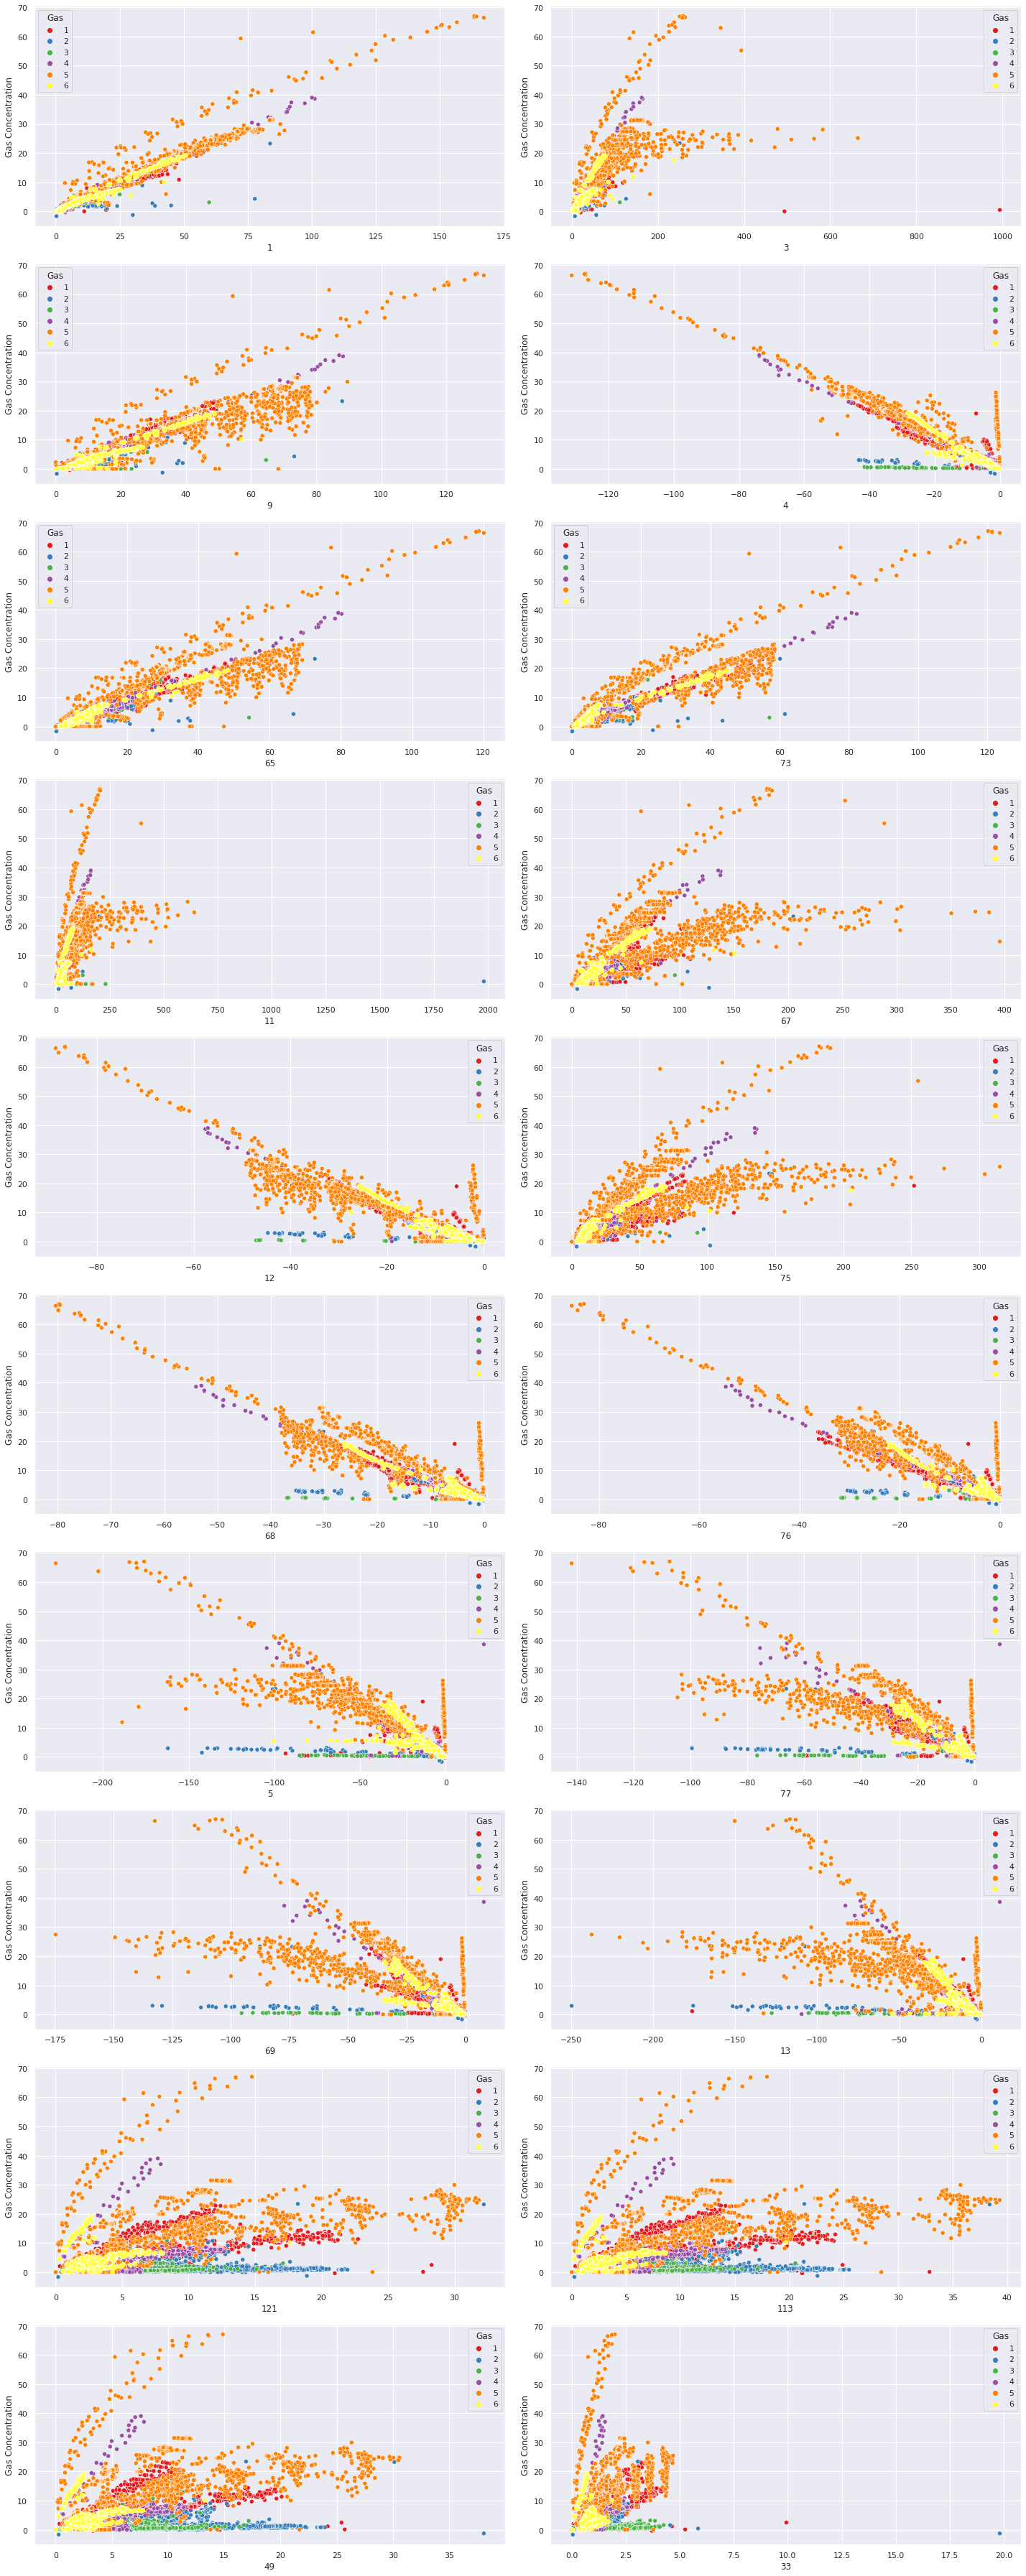

In [ ]:
fig = plt.figure(figsize=(20,50))
for i in range(0,20):
    fig.add_subplot(10,2,i+1)
    sns.scatterplot(attr.iloc[:,conc_corr.index[i]],conc_red, hue="Gas", palette= "Set1", data=df, legend="full")
    plt.xlabel(conc_corr.index[i])
    plt.ylabel("Gas Concentration")
    
fig.tight_layout()    
plt.show()

### PCA 적용

#### 1) 데이터 준비

In [ ]:
df_copy = df.copy() 

X = df_copy.iloc[:,1:]
y = df_copy.iloc[:,0]

In [ ]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: Gas, dtype: int64

In [ ]:
X.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128
0,15596.1621,1.868245,2.371604,2.803678,7.512213,-2.739388,-3.344671,-4.847512,15326.6914,1.768526,2.269085,2.713374,6.915721,-2.488324,-3.082212,-5.056975,2789.3831,2.754759,0.430440,0.649457,1.795029,-0.426662,-0.584313,-1.438976,2581.5686,2.680623,0.399746,0.605065,1.786704,-0.400115,-0.550743,-1.728611,685.3994,1.682904,0.122736,0.223703,0.584691,-0.138196,-0.236907,-0.781959,...,2185.9741,2.949381,0.342575,0.515090,1.340477,-0.361030,-0.493482,-1.200617,862.7479,1.779291,0.165138,0.246473,1.358106,-0.187465,-0.416382,-1.058061,1059.7562,1.896047,0.198946,0.334017,0.815048,-0.204467,-0.345119,-0.969336,3357.1124,3.860647,0.580818,0.806830,1.729739,-0.619214,-1.071137,-3.037772,3037.0390,3.972203,0.527291,0.728443,1.445783,-0.545079,-0.902241,-2.654529
1,63977.7696,4.167595,16.585249,23.251074,30.609595,-13.523380,-18.412358,-63.868994,48405.8652,2.754066,13.497138,19.958221,33.281066,-11.275762,-16.037687,-48.807572,11817.0930,4.572676,3.073228,6.686113,8.987955,-2.794705,-4.114651,-8.799352,12009.9065,4.486397,3.191784,6.814771,9.890921,-2.864425,-4.244426,-7.519559,3966.5544,2.951857,1.472888,3.933471,7.115419,-1.085608,-1.903061,-4.753987,...,11422.9468,4.692882,3.156244,6.612181,9.238423,-2.723495,-4.131521,-9.224363,4467.6554,3.192842,1.698924,4.693181,8.130750,-1.210260,-2.090758,-5.359044,3864.4237,3.029658,1.399340,4.056797,6.528611,-1.017463,-1.880344,-5.620730,18836.5937,5.165475,6.237392,14.031837,18.910534,-5.373498,-9.151316,-20.096582,16536.5271,5.146451,5.920137,14.026265,18.070481,-4.893835,-8.622448,-16.032358
2,85799.9199,5.391654,22.510086,31.963378,44.852442,-17.641179,-24.564141,-107.636673,66325.9082,3.496136,18.456762,28.162225,38.541891,-14.943008,-21.976508,-80.793801,17674.5044,6.788889,4.547327,8.332182,11.314767,-4.247248,-6.536620,-13.367045,17895.5112,6.602047,4.663164,8.735594,11.403216,-4.356930,-6.626092,-14.237014,5576.2280,3.844258,1.967586,4.774495,7.362195,-1.494095,-2.591652,-5.110862,...,16954.0144,6.901817,4.584255,8.411523,11.081576,-4.051694,-6.371402,-12.630358,6248.5824,4.216960,2.235465,5.691430,8.955101,-1.675226,-2.919773,-6.685465,5502.7336,4.039914,1.828858,4.786054,7.699655,-1.425835,-2.446651,-6.289898,28205.7730,7.731637,9.342144,18.053748,21.575025,-8.224113,-14.613964,-27.706487,24568.0573,7.695328,8.698242,17.799126,22.388913,-7.400848,-13.436990,-26.384947
3,4409.8086,1.213460,3.406728,6.188410,10.552296,-1.356137,-2.284334,-10.406550,1867.1621,1.065751,2.977926,6.075863,13.779786,-1.356440,-2.422959,-12.605521,999.4246,1.297679,1.177730,3.799299,7.103504,-0.313990,-0.614501,-3.026209,1052.9285,1.302524,1.237472,3.931129,7.074447,-0.331318,-0.651927,-2.728831,472.2039,1.233715,0.722117,2.478192,5.261009,-0.170893,-0.490865,-2.351480,...,1012.8112,1.316126,1.212298,3.632647,6.242435,-0.326712,-0.663904,-3.283598,590.9350,1.291361,0.875219,3.050917,5.722232,-0.201898,-0.510264,-3.027299,493.0159,1.259506,0.754185,2.692012,5.180458,-0.181103,-0.489525,-2.879709,1818.6533,1.391062,2.705440,8.574963,12.827542,-0.587286,-1.050682,-4.506671,1670.9245,1.413573,2.598768,8.587894,12.007572,-0.539856,-0.979863,-3.640232
4,64055.1973,4.105238,16.755247,23.226888,32.291462,-13.621875,-18.514037,-63.210391,48343.5762,2.728235,13.541813,20.079315,29.759307,-11.241122,-15.584867,-57.951439,11747.9180,4.546815,3.106561,6.774248,9.239448,-2.794424,-4.238900,-9.237991,11910.9485,4.432412,3.219480,6.822684,9.680207,-2.860117,-4.445493,-8.143785,3965.6500,2.952543,1.479039,3.847498,6.379700,-1.080555,-1.828659,-3.740131,...,11330.8694,4.630623,3.168742,6.593356,9.613930,-2.702708,-4.122085,-9.144837,4442.8331,3.180153,1.691856,4.621961,7.487482,-1.210097,-2.187651,-5.973421,3881.2165,3.036504,1.396383,4.104580,7.075910,-1.027726

#### 2) 테스트 모델 생성

In [ ]:
pca = PCA(n_components=3)
X_train = pca.fit_transform(X)

#### 3) 그래프

##### 평면 그래프

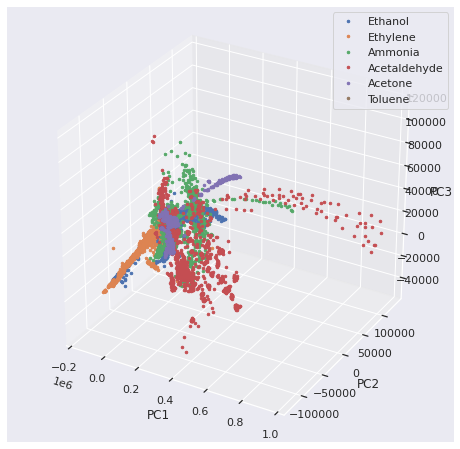

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.rcParams['legend.fontsize'] = 11   
ax.plot(X_train[0:2564,0], X_train[0:2564,1], X_train[0:2564,2], 'o', markersize=2.5, label='Ethanol')
ax.plot(X_train[2565:5490,0], X_train[2565:5490,1], X_train[2565:5490,2], 'o', markersize=2.5, label='Ethylene')
ax.plot(X_train[5491:7131,0], X_train[5491:7131,1], X_train[5491:7131,2], 'o', markersize=2.5, label='Ammonia')
ax.plot(X_train[7132:9067,0], X_train[7132:9067,1], X_train[7132:9067,2], 'o', markersize=2.5, label='Acetaldehyde')
ax.plot(X_train[9068:12076,0], X_train[9068:12076,1], X_train[9068:12076,2], 'o', markersize=2.5, label='Acetone')
ax.plot(X_train[12077:13909,0], X_train[12077:13909,1], X_train[12077:13909,2], 'o', markersize=2.5, label='Toluene')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend(loc='upper right')

plt.show()

##### t-SNE 그래프

In [ ]:
tsne= TSNE(n_components=3,n_iter=3000)
xtrain=tsne.fit_transform(X)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.rcParams['legend.fontsize'] = 11   
ax.plot(xtrain[0:2564,0], xtrain[0:2564,1], xtrain[0:2564,2], 'o', markersize=2.5, label='Ethanol')
ax.plot(xtrain[2565:5490,0], xtrain[2565:5490,1], xtrain[2565:5490,2], 'o', markersize=2.5, label='Ethylene')
ax.plot(xtrain[5491:7131,0], xtrain[5491:7131,1], xtrain[5491:7131,2], 'o', markersize=2.5, label='Ammonia')
ax.plot(xtrain[7132:9067,0], xtrain[7132:9067,1], xtrain[7132:9067,2], 'o', markersize=2.5, label='Acetaldehyde')
ax.plot(xtrain[9068:12076,0], xtrain[9068:12076,1], xtrain[9068:12076,2], 'o', markersize=2.5, label='Acetone')
ax.plot(xtrain[12077:13909,0], xtrain[12077:13909,1], xtrain[12077:13909,2], 'o', markersize=2.5, label='Toluene')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend(loc='upper right')
plt.show()

#### 4) Scailing

In [ ]:
X_scaled = X.copy()
X_scaled = StandardScaler().fit(X_scaled).transform(X_scaled)

#### 5) PCA Step 1 - Covariance Matrix 만들기

In [ ]:
cov_matrix = np.cov(X_scaled.T)

#### 6) PCA Step 2 - Eigen Values 와 Eigen Vector 만들기

In [ ]:
eig_val, eig_vec = np.linalg.eig(cov_matrix)
print('Eigenvectors \n%s' %eig_vec)
print('\nEigenvalues \n%s' %eig_val)

Eigenvectors 
[[-6.57680183e-02  1.64978553e-01  9.41278208e-02 ... -7.16608753e-03
  -5.95257777e-04  7.89467103e-03]
 [-3.56837717e-02 -2.15103628e-02  2.37518695e-01 ...  4.20028944e-04
   1.90129590e-04  7.83641879e-04]
 [-7.14779412e-02  1.56396457e-01  1.00566517e-01 ... -1.19794353e-02
   1.07818517e-02  8.13080242e-03]
 ...
 [ 1.13770787e-01 -2.41244558e-02  5.11663634e-02 ... -4.65795721e-01
  -6.65666018e-02  3.74596744e-02]
 [ 1.11274348e-01 -2.52559770e-02  9.01646446e-02 ...  8.70024314e-02
   1.48749272e-02 -2.28997071e-02]
 [ 8.44630452e-02 -3.59689710e-02  1.60255010e-01 ...  1.03592633e-03
  -4.84895019e-03  4.02693865e-03]]

Eigenvalues 
[6.81958295e+01 1.89589872e+01 8.02838849e+00 6.78022060e+00
 4.38477225e+00 3.72628851e+00 3.10767726e+00 2.14748217e+00
 1.93638682e+00 1.58725223e+00 1.35100038e+00 1.08203947e+00
 8.43136361e-01 7.97362353e-01 6.65176045e-01 5.70189668e-01
 3.88714899e-01 3.69249259e-01 3.36819798e-01 3.04154374e-01
 2.65326678e-01 2.31828020e-01 

In [ ]:
tot = sum(eig_val)
var_exp = [( i /tot ) * 100 for i in sorted(eig_val, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print("누적 분산 설명력", cum_var_exp)

누적 분산 설명력 [ 53.27281769  68.083088    74.35465738  79.6511903   83.07646095
  85.98734112  88.4149782   90.09253571  91.60519099  92.84511137
  93.90047791  94.74573915  95.40437546  96.0272543   96.54687262
  96.99229004  97.29594406  97.58439203  97.84750694  98.08510447
  98.29237081  98.47346886  98.64290197  98.77449112  98.89543955
  99.00783     99.101529    99.18122378  99.2575557   99.31320915
  99.36405698  99.40715957  99.44786405  99.48510509  99.52046806
  99.5541993   99.58356089  99.61099378  99.63672639  99.66077616
  99.68367923  99.70323267  99.72190468  99.73945714  99.75543445
  99.77101644  99.78513586  99.79880342  99.81162613  99.82399109
  99.83519085  99.84599169  99.85635033  99.86572153  99.87423495
  99.88219512  99.88995155  99.89742844  99.90398045  99.91040223
  99.91608693  99.92121471  99.92612364  99.93096833  99.9355525
  99.93980278  99.94387077  99.94743412  99.95076153  99.95392045
  99.95682668  99.95968312  99.96236666  99.96499686  99.96744421
 

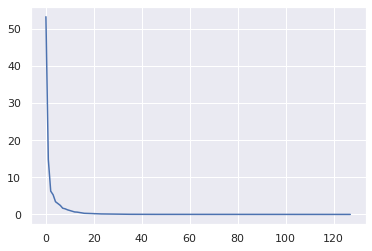

In [ ]:
plt.plot(var_exp)

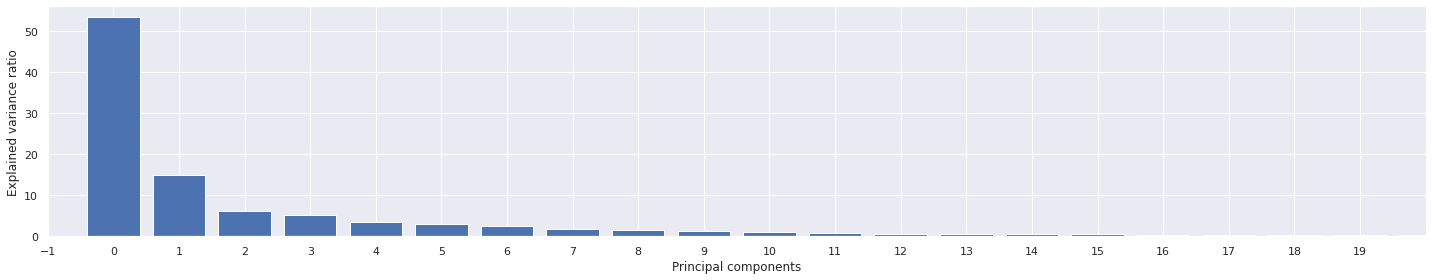

In [ ]:
plt.figure(figsize=(20, 4))
plt.bar(range(128), var_exp)
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.xlim(0,20)
plt.xticks(range(-1, 20))
plt.tight_layout()

#### 7) Scikit-learn 으로 PCA 적용하기

In [ ]:
pca = PCA()
X_scaled = pca.fit_transform(X_scaled)

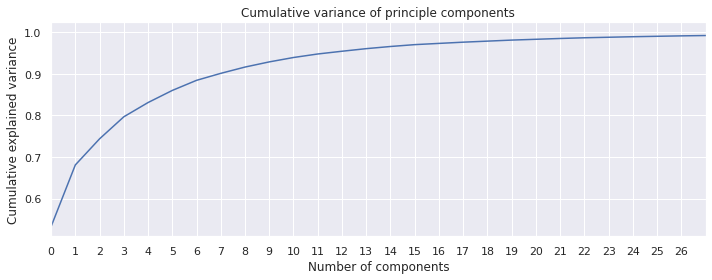

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,27)
plt.xticks(range(0,27))
plt.title('Cumulative variance of principle components')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.tight_layout()

In [ ]:
print(pca.explained_variance_ratio_)

[5.32728177e-01 1.48102703e-01 6.27156938e-02 5.29653292e-02
 3.42527064e-02 2.91088018e-02 2.42763708e-02 1.67755751e-02
 1.51265528e-02 1.23992037e-02 1.05536655e-02 8.45261238e-03
 6.58636312e-03 6.22878841e-03 5.19618317e-03 4.45417417e-03
 3.03654023e-03 2.88447968e-03 2.63114912e-03 2.37597528e-03
 2.07266336e-03 1.81098051e-03 1.69433116e-03 1.31589145e-03
 1.20948433e-03 1.12390454e-03 9.36989989e-04 7.96947799e-04
 7.63319166e-04 5.56534499e-04 5.08478266e-04 4.31025975e-04
 4.07044765e-04 3.72410380e-04 3.53629721e-04 3.37312360e-04
 2.93615979e-04 2.74328860e-04 2.57326100e-04 2.40497663e-04
 2.29030758e-04 1.95534392e-04 1.86720092e-04 1.75524565e-04
 1.59773089e-04 1.55819901e-04 1.41194199e-04 1.36675691e-04
 1.28227046e-04 1.23649572e-04 1.11997681e-04 1.08008366e-04
 1.03586352e-04 9.37120699e-05 8.51341714e-05 7.96016876e-05
 7.75643041e-05 7.47689421e-05 6.55200510e-05 6.42178510e-05
 5.68469546e-05 5.12777520e-05 4.90893264e-05 4.84469294e-05
 4.58416753e-05 4.250279

> 12개의 성분만으로 약 95%의 설명력을 가질 수 있음

## 다양한 Classifier 를 활용한 가스 성분 분류 모델 생성

#### 모델링 준비

##### Label Encoding

In [ ]:
from sklearn.preprocessing import label_binarize

y_ohe = label_binarize(y, classes=[1,2,3,4,5,6])

n_classes = y_ohe.shape[1]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=4)

y_train_nobinary = y_train.copy()
y_test_nobinary = y_test.copy()

# Scailing
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = label_binarize(y_train, classes=[1,2,3,4,5,6])
y_test = label_binarize(y_test, classes=[1,2,3,4,5,6])

##### ROC Curve Function 생성

In [ ]:
def plot_roc(y_test,y_pred,title):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes
    lw=2
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.3f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.3f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

##### Confusion Plot Function 생성

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,random_state=4)

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### 기본 모델링

##### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

clf = RandomForestClassifier()
random=clf.fit(X_train,y_train)

y_pred =random.predict(X_test)
print('ground truth           :',y_test)
print('predicted class        :',y_pred)
print('ground truth           :',y_test)
print('predicted class        :',y_pred)
print('cross validation acc   :',cross_val_score(random,X_test,y_test).mean())

ground truth           : 753      1
6659     5
10020    6
10214    6
5622     4
        ..
9087     6
8967     5
4798     3
3039     2
8486     5
Name: Gas, Length: 2060, dtype: int64
predicted class        : [1 5 6 ... 3 2 5]
ground truth           : 753      1
6659     5
10020    6
10214    6
5622     4
        ..
9087     6
8967     5
4798     3
3039     2
8486     5
Name: Gas, Length: 2060, dtype: int64
predicted class        : [1 5 6 ... 3 2 5]
cross validation acc   : 0.9820388349514564


> Confusion Matrix

Confusion matrix, without normalization
[[379   0   0   0   0   0]
 [  0 447   1   0   0   0]
 [  0   2 255   0   5   0]
 [  0   0   0 238   0   0]
 [  0   0   0   0 456   1]
 [  0   0   0   2   0 274]]
Normalized confusion matrix
[[1.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.  ]
 [0.   0.01 0.97 0.   0.02 0.  ]
 [0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.01 0.   0.99]]


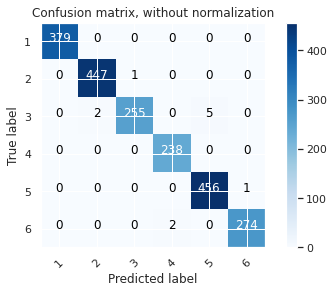

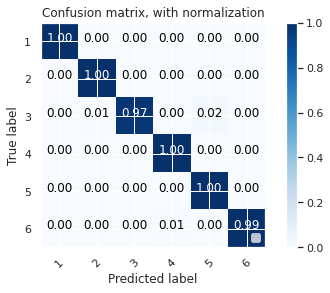

In [ ]:

cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

plt.figure()
class_names=['1','2','3','4','5','6']
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Confusion matrix, with normalization')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

##### Ada Boost

In [ ]:

from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score

ada=AdaBoostClassifier(n_estimators=10)
ada=ada.fit(X_train,y_train)

y_pred =ada.predict(X_test)
print('ground truth           :',y_test)
print('predicted class        :',y_pred)
print('ground truth           :',y_test)
print('predicted class        :',y_pred)

ground truth           : 753      1
6659     5
10020    6
10214    6
5622     4
        ..
9087     6
8967     5
4798     3
3039     2
8486     5
Name: Gas, Length: 2060, dtype: int64
predicted class        : [1 5 6 ... 3 2 5]
ground truth           : 753      1
6659     5
10020    6
10214    6
5622     4
        ..
9087     6
8967     5
4798     3
3039     2
8486     5
Name: Gas, Length: 2060, dtype: int64
predicted class        : [1 5 6 ... 3 2 5]


> Confusion Matrix

Confusion matrix, without normalization
[[250   3   0  86  20  20]
 [ 38 194 212   0   0   4]
 [ 14  80 165   0   3   0]
 [106   0   0  74   7  51]
 [ 57   1   0  13 386   0]
 [ 22   1   1  54  22 176]]
Normalized confusion matrix
[[0.66 0.01 0.   0.23 0.05 0.05]
 [0.08 0.43 0.47 0.   0.   0.01]
 [0.05 0.31 0.63 0.   0.01 0.  ]
 [0.45 0.   0.   0.31 0.03 0.21]
 [0.12 0.   0.   0.03 0.84 0.  ]
 [0.08 0.   0.   0.2  0.08 0.64]]


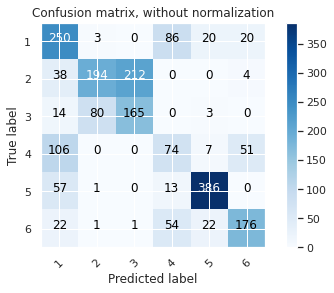

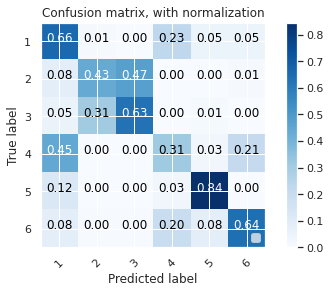

In [ ]:
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

plt.figure()
class_names=['1','2','3','4','5','6']
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Confusion matrix, with normalization')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

##### Bagging with KNN

ground truth           : 753      1
6659     5
10020    6
10214    6
5622     4
        ..
9087     6
8967     5
4798     3
3039     2
8486     5
Name: Gas, Length: 2060, dtype: int64
predicted class        : [1 5 6 ... 3 2 5]
ground truth           : 753      1
6659     5
10020    6
10214    6
5622     4
        ..
9087     6
8967     5
4798     3
3039     2
8486     5
Name: Gas, Length: 2060, dtype: int64
predicted class        : [1 5 6 ... 3 2 5]
cross validation acc   : 0.8495145631067962
Confusion matrix, without normalization
[[374   0   0   4   0   1]
 [  2 435   1  10   0   0]
 [  0  19 235   1   7   0]
 [  8   1   0 221   2   6]
 [  1   0   0   1 434  21]
 [  1   0   0   2   0 273]]
Normalized confusion matrix
[[0.99 0.   0.   0.01 0.   0.  ]
 [0.   0.97 0.   0.02 0.   0.  ]
 [0.   0.07 0.9  0.   0.03 0.  ]
 [0.03 0.   0.   0.93 0.01 0.03]
 [0.   0.   0.   0.   0.95 0.05]
 [0.   0.   0.   0.01 0.   0.99]]


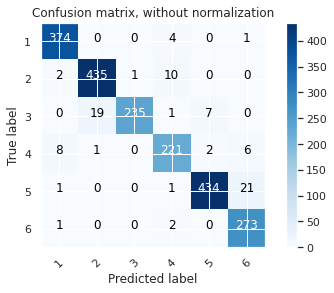

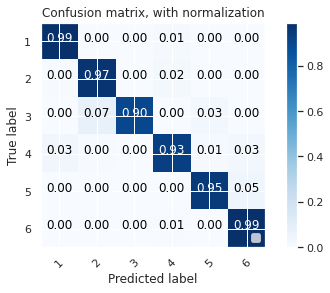

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier

bagging = BaggingClassifier(KNeighborsClassifier(n_neighbors=14),
                            max_samples=0.5, max_features=0.5)

bagging=bagging.fit(X_train,y_train)

y_pred =bagging.predict(X_test)
print('ground truth           :',y_test)
print('predicted class        :',y_pred)
print('ground truth           :',y_test)
print('predicted class        :',y_pred)
print('cross validation acc   :',cross_val_score(bagging,X_test,y_test).mean())

> Confusion Matrix

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
class_names=['1','2','3','4','5','6']
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Confusion matrix, with normalization')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

##### Decision Tree

ground truth           : 753      1
6659     5
10020    6
10214    6
5622     4
        ..
9087     6
8967     5
4798     3
3039     2
8486     5
Name: Gas, Length: 2060, dtype: int64
predicted class        : [1 5 6 ... 3 2 5]
ground truth           : 753      1
6659     5
10020    6
10214    6
5622     4
        ..
9087     6
8967     5
4798     3
3039     2
8486     5
Name: Gas, Length: 2060, dtype: int64
predicted class        : [1 5 6 ... 3 2 5]
cross validation acc   : 0.9150485436893204
Confusion matrix, without normalization
[[362   0   2   9   6   0]
 [  3 437   7   0   1   0]
 [  0  11 240   1   9   1]
 [  7   0   0 220   3   8]
 [  0   2   2   0 446   7]
 [  0   4   0   9   1 262]]
Normalized confusion matrix
[[0.96 0.   0.01 0.02 0.02 0.  ]
 [0.01 0.98 0.02 0.   0.   0.  ]
 [0.   0.04 0.92 0.   0.03 0.  ]
 [0.03 0.   0.   0.92 0.01 0.03]
 [0.   0.   0.   0.   0.98 0.02]
 [0.   0.01 0.   0.03 0.   0.95]]


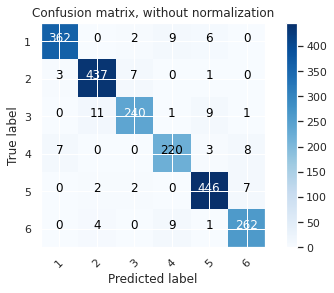

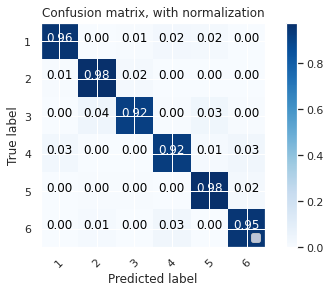

In [ ]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
tree=clf.fit(X_train,y_train)

y_pred =tree.predict(X_test)
print('ground truth           :',y_test)
print('predicted class        :',y_pred)
print('ground truth           :',y_test)
print('predicted class        :',y_pred)
print('cross validation acc   :',cross_val_score(tree,X_test,y_test).mean())

> Confusion Matrix

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
class_names=['1','2','3','4','5','6']
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Confusion matrix, with normalization')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

##### Majority Voting Ensemble Machine

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


ground truth           : 753      1
6659     5
10020    6
10214    6
5622     4
        ..
9087     6
8967     5
4798     3
3039     2
8486     5
Name: Gas, Length: 2060, dtype: int64
predicted class        : [1 5 6 ... 3 2 5]
ground truth           : 753      1
6659     5
10020    6
10214    6
5622     4
        ..
9087     6
8967     5
4798     3
3039     2
8486     5
Name: Gas, Length: 2060, dtype: int64
predicted class        : [1 5 6 ... 3 2 5]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://sci

cross validation acc   : 0.9524271844660195
Confusion matrix, without normalization
[[379   0   0   0   0   0]
 [  2 442   2   2   0   0]
 [  0   8 247   0   7   0]
 [  5   0   0 233   0   0]
 [  2   1   1   0 452   1]
 [  1   0   0   3   1 271]]
Normalized confusion matrix
[[1.   0.   0.   0.   0.   0.  ]
 [0.   0.99 0.   0.   0.   0.  ]
 [0.   0.03 0.94 0.   0.03 0.  ]
 [0.02 0.   0.   0.98 0.   0.  ]
 [0.   0.   0.   0.   0.99 0.  ]
 [0.   0.   0.   0.01 0.   0.98]]


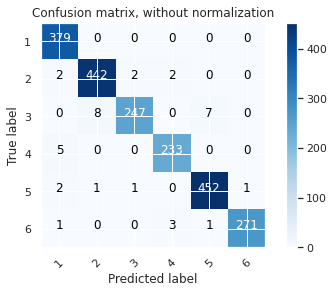

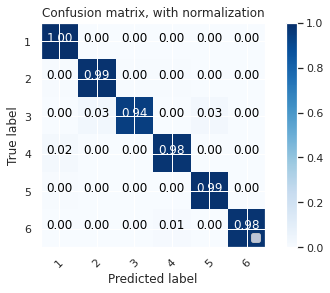

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

clf1 = LogisticRegression()
clf2= DecisionTreeClassifier()
clf3= LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
clf4= KNeighborsClassifier(n_neighbors=30)
eclf = VotingClassifier(estimators=[('lr', clf1), ('dt', clf2), ('svm', clf3),('knn',clf4)], voting='hard')
eclf = eclf.fit(X_train,y_train)
y_pred =eclf.predict(X_test)
print('ground truth           :',y_test)
print('predicted class        :',y_pred)
print('ground truth           :',y_test)
print('predicted class        :',y_pred)
print('cross validation acc   :',cross_val_score(eclf,X_test,y_test).mean())


> Confusion Matrix

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
class_names=['1','2','3','4','5','6']
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Confusion matrix, with normalization')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

##### Logistic Regression

> OneVsRestClassifier 는 클래스마다 분류기를 하나씩 만들어서 학습시키는 Classifier

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from scipy import interp
from itertools import cycle

start = time.time()

# Learn to predict each class against the other
classifier = OneVsRestClassifier(LogisticRegression(solver='sag',n_jobs=-1))
classifier.fit(X_train, y_train)
y_pred1 = classifier.predict_proba(X_test)

end = time.time()
print("\nTime taken: {:.2f} seconds".format(end-start))


Time taken: 7.41 seconds


> Confusion Matrix

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test.argmax(axis=1),y_pred1.argmax(axis=1))
confusion_matrix

array([[357,   4,   0,  12,   4,   2],
       [  0, 447,   0,   0,   0,   1],
       [  0,   9, 231,   1,   8,  13],
       [ 24,   2,   0, 151,   0,  61],
       [  1,   0,   0,   2, 445,   9],
       [  0,   0,   0,   2,  14, 260]])

In [ ]:
auc_roc = metrics.classification_report(np.argmax(y_test, axis=1),np.argmax(y_pred1, axis=1))
print('Logistic Regression Classification Report:\n {}'.format(auc_roc))

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.94       379
           1       0.97      1.00      0.98       448
           2       1.00      0.88      0.94       262
           3       0.90      0.63      0.74       238
           4       0.94      0.97      0.96       457
           5       0.75      0.94      0.84       276

    accuracy                           0.92      2060
   macro avg       0.92      0.90      0.90      2060
weighted avg       0.92      0.92      0.92      2060



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


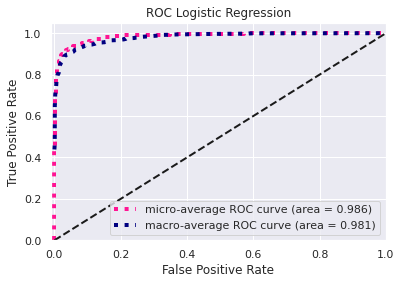

In [ ]:
plot_roc(y_test,y_pred1,"ROC Logistic Regression")

##### SVC

In [ ]:
from sklearn.svm import SVC

start = time.time()

classifier = OneVsRestClassifier(SVC(kernel="linear",verbose=1, decision_function_shape='ovr', probability=True))
classifier.fit(X_train, y_train)
y_pred2 = classifier.predict_proba(X_test)

end = time.time()
print("\nTime taken: {:.2f} seconds".format(end-start))

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]
Time taken: 27.15 seconds


> Confusion Matrix

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test.argmax(axis=1),y_pred2.argmax(axis=1))
confusion_matrix

array([[376,   1,   0,   2,   0,   0],
       [  0, 447,   1,   0,   0,   0],
       [  0,   3, 251,   0,   7,   1],
       [  1,   0,   0, 236,   0,   1],
       [  1,   0,   0,   1, 454,   1],
       [  0,   0,   0,   0,   0, 276]])

In [ ]:
auc_roc = metrics.classification_report(np.argmax(y_test, axis=1),np.argmax(y_pred2, axis=1))
print('SVC Classification Report:\n {}'.format(auc_roc))

SVC Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       379
           1       0.99      1.00      0.99       448
           2       1.00      0.96      0.98       262
           3       0.99      0.99      0.99       238
           4       0.98      0.99      0.99       457
           5       0.99      1.00      0.99       276

    accuracy                           0.99      2060
   macro avg       0.99      0.99      0.99      2060
weighted avg       0.99      0.99      0.99      2060



**We will use the macro average method to evaluate the algorithm.**

### Feature Selction 을 활용한 모델링

* ROC(Receiver Operating Characteristic) : 모든 임계값에서 분류 모델의 성능을 보여주는 그래프
* AUC(Area Under the Curve) : ROC 곡선 아래 영역을 의미함

#### Logistic regression with RFE

In [ ]:
from sklearn.feature_selection import RFE

start = time.time()

classifier = OneVsRestClassifier(LogisticRegression(solver='sag',n_jobs=-1))
rfe = RFE(classifier, n_features_to_select=64,verbose=1,step=1)
rfe = rfe.fit(X_train, y_train_nobinary)

end = time.time()
print("\nTime taken: {:.2f} seconds".format(end-start))

Fitting estimator with 128 features.
Fitting estimator with 127 features.
Fitting estimator with 126 features.
Fitting estimator with 125 features.
Fitting estimator with 124 features.
Fitting estimator with 123 features.
Fitting estimator with 122 features.
Fitting estimator with 121 features.
Fitting estimator with 120 features.
Fitting estimator with 119 features.
Fitting estimator with 118 features.
Fitting estimator with 117 features.
Fitting estimator with 116 features.
Fitting estimator with 115 features.
Fitting estimator with 114 features.
Fitting estimator with 113 features.
Fitting estimator with 112 features.
Fitting estimator with 111 features.
Fitting estimator with 110 features.
Fitting estimator with 109 features.
Fitting estimator with 108 features.
Fitting estimator with 107 features.
Fitting estimator with 106 features.
Fitting estimator with 105 features.
Fitting estimator with 104 features.
Fitting estimator with 103 features.
Fitting estimator with 102 features.
F

In [ ]:
# RFE 알고리즘에 의해 선택된 Feature 리스트
features = X.columns[rfe.support_]
print(features)
X_train_rfe = pd.DataFrame(X_train)[features]
X_test_rfe = pd.DataFrame(X_test)[features]

In [ ]:
classifier = OneVsRestClassifier(LogisticRegression(solver='sag',n_jobs=-1))
classifier.fit(X_train_rfe, y_train)
y_pred11 = classifier.predict_proba(X_test_rfe)

> Confusion Matrix

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test.argmax(axis=1),y_pred11.argmax(axis=1))
confusion_matrix

array([[360,   3,   0,  15,   1,   0],
       [  0, 445,   0,   1,   1,   1],
       [  0,  15, 230,   1,   8,   8],
       [ 19,   1,   0, 160,   0,  58],
       [  1,   0,   0,   3, 449,   4],
       [  0,   0,   0,  11,  18, 247]])

In [ ]:
auc_roc = metrics.classification_report(np.argmax(y_test, axis=1),np.argmax(y_pred11, axis=1))
print('Logistic regression with Recursive Feature Elimination:\n {}'.format(auc_roc))

Logistic regression with Recursive Feature Elimination:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95       379
           1       0.96      0.99      0.98       448
           2       1.00      0.88      0.93       262
           3       0.84      0.67      0.75       238
           4       0.94      0.98      0.96       457
           5       0.78      0.89      0.83       276

    accuracy                           0.92      2060
   macro avg       0.91      0.90      0.90      2060
weighted avg       0.92      0.92      0.92      2060



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


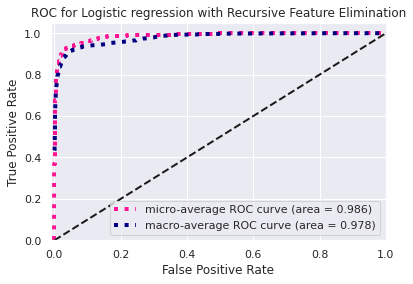

In [ ]:
plot_roc(y_test,y_pred11,'ROC for Logistic regression with Recursive Feature Elimination')

#### Logistic regression with SelectKBest (Chi Square test)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import chi2 ,SelectKBest

# MinMaxScaler 적용
norm = MinMaxScaler()
X_train_norm = norm.fit_transform(X_train)

In [ ]:
selector = SelectKBest(chi2, k=64)
selector.fit(X_train_norm, y_train)
X_train_kbest = selector.transform(X_train)
X_test_kbest = selector.transform(X_test)

In [ ]:
classifier = OneVsRestClassifier(LogisticRegression(solver='sag',n_jobs=-1))
classifier.fit(X_train_kbest, y_train)
y_pred12 = classifier.predict_proba(X_test_kbest)

> Confusion Matrix

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test.argmax(axis=1),y_pred12.argmax(axis=1))
confusion_matrix

array([[369,   2,   0,   8,   0,   0],
       [  0, 447,   1,   0,   0,   0],
       [  0,   4, 247,   1,   7,   3],
       [  6,   0,   0, 205,   0,  27],
       [  0,   1,   0,   4, 450,   2],
       [  0,   0,   0,  12,   0, 264]])

In [ ]:
auc_roc = metrics.classification_report(np.argmax(y_test, axis=1),np.argmax(y_pred12, axis=1))
print('Logistic regression with chi2 test feature selection:\n {}'.format(auc_roc))

Logistic regression with chi2 test feature selection:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98       379
           1       0.98      1.00      0.99       448
           2       1.00      0.94      0.97       262
           3       0.89      0.86      0.88       238
           4       0.98      0.98      0.98       457
           5       0.89      0.96      0.92       276

    accuracy                           0.96      2060
   macro avg       0.96      0.95      0.95      2060
weighted avg       0.96      0.96      0.96      2060



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


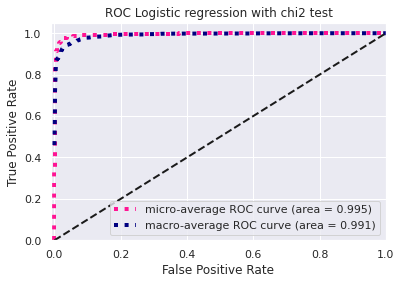

In [ ]:
plot_roc(y_test,y_pred12,'ROC Logistic regression with chi2 test')

#### SVC with RFE

In [ ]:
classifier = OneVsRestClassifier(SVC(kernel="linear", decision_function_shape='ovr'))
rfe = RFE(classifier, n_features_to_select=64,verbose=1,step=1)
rfe = rfe.fit(X_train, y_train_nobinary)

In [ ]:
features = pd.DataFrame(X_train).columns[rfe.support_]
print(features)
X_train_rfe = pd.DataFrame(X_train)[features]
X_test_rfe = pd.DataFrame(X_test)[features]

In [ ]:
classifier = OneVsRestClassifier(SVC(kernel="linear",probability=True, verbose=1, decision_function_shape='ovr'))
classifier.fit(X_train_rfe, y_train)
y_pred21 = classifier.predict_proba(X_test_rfe)

In [ ]:
confusion_matrix = metrics.confusion_matrix(np.argmax(y_test, axis=1),np.argmax(y_pred21, axis=1))
confusion_matrix

In [ ]:
auc_roc = metrics.classification_report(np.argmax(y_test, axis=1),np.argmax(y_pred21, axis=1))
print('SVC with Recursive Feature Elimination:\n {}'.format(auc_roc))

In [ ]:
plot_roc(y_test,y_pred21,'ROC for SVC with Recursive Feature Elimination')

#### SVC with SelectKBest(chi2 test)

In [ ]:
classifier = OneVsRestClassifier(SVC(kernel="linear",probability=True , verbose=1, decision_function_shape='ovr'))
classifier.fit(X_train_kbest, y_train)
y_pred22 = classifier.predict_proba(X_test_kbest)


In [ ]:
confusion_matrix = metrics.confusion_matrix(np.argmax(y_test, axis=1),np.argmax(y_pred22, axis=1))
confusion_matrix

In [ ]:
auc_roc = metrics.classification_report(np.argmax(y_test, axis=1),np.argmax(y_pred22, axis=1))
print('SVC with chi2 test feature selection:\n {}'.format(auc_roc))

In [ ]:
plot_roc(y_test,y_pred22,'ROC for SVC with feature selection based on chi2 test')